In [2]:
import pandas as pd
import re
from sklearn.feature_extraction import text
# from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from itertools import accumulate
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import itertools

# 读取数据
data = pd.read_csv(r"./all_data.tsv", sep='\t',escapechar='\\')
# data2 = pd.read_csv(r"./imdb_train_test.tsv", sep='\t')

def load_stopwords(filepath):
    stopwords_final = []
    #2 ollect words from files. Each word is on one line
    file = open(filepath,"r",encoding="utf-8") #"stopwords-master/baidu.txt"
    for line in file:
        line = line.strip()
        stopwords_final.append(line)
    file.close()
    return stopwords_final

def clean_review(raw_review):
    # 1. 评论是爬虫抓取的，存在一些 html 标签，需要去掉
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 标点符号只保留 “-” 和 上单引号
    review_text = rex.sub(' ', review_text)
    # 3. 全部变成小写
    review_text = review_text.lower()
    # 4. 分词
    word_list = review_text.split()
    # 5. 词性还原
#     tokens = list(map(lemmatizer.lemmatize, word_list))
#     lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 6. 去停用词
    meaningful_words = [x for x in word_list if x not in stop_words] #list(filter(lambda x: not x in stop_words))#, lemmatized_tokens
    return meaningful_words

stopwords_filepath = "stop_all.txt"
# stop_words = set(text.ENGLISH_STOP_WORDS)
stop_words = load_stopwords(stopwords_filepath)
rex = re.compile(r'[!"#$%&\()*+,./:;<=>?@\\^_{|}~]+')
# lemmatizer = WordNetLemmatizer()

sentences  = data.sentence.apply(clean_review)

In [3]:
sentences[0]

['bromwell',
 'high',
 'cartoon',
 'comedy',
 'ran',
 'time',
 'programs',
 'school',
 'life',
 'teachers',
 '35',
 'years',
 'teaching',
 'profession',
 'lead',
 'bromwell',
 "high's",
 'satire',
 'closer',
 'reality',
 'teachers',
 'scramble',
 'survive',
 'financially',
 'insightful',
 'students',
 'pathetic',
 "teachers'",
 'pomp',
 'pettiness',
 'situation',
 'remind',
 'schools',
 'i',
 'knew',
 'students',
 'i',
 'episode',
 'student',
 'repeatedly',
 'burn',
 'school',
 'i',
 'immediately',
 'recalled',
 'high',
 'classic',
 'line',
 'inspector',
 'sack',
 'teachers',
 'student',
 'bromwell',
 'high',
 'i',
 'expect',
 'adults',
 'age',
 'bromwell',
 'high',
 'fetched',
 'pity']

In [4]:
len(sentences)

75000

In [7]:
cal_len = pd.DataFrame()
cal_len['review_length'] = list(map(len, sentences))
print("中位数：", cal_len['review_length'].median())
print("均值数：", cal_len['review_length'].mean())
del cal_len

中位数： 73.0
均值数： 98.32914666666667


In [8]:
data['length'] = data['sentence'].apply(lambda x: len(x))
len_df = data.groupby('length').count()
sent_length = len_df.index.tolist()
sent_freq = len_df['sentence'].tolist()

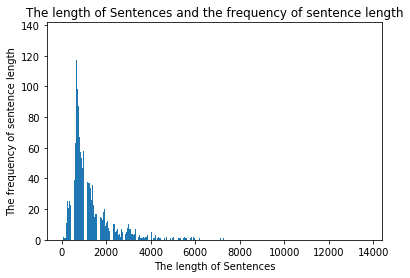

In [9]:

# 绘制句子长度及出现频数统计图
plt.bar(sent_length, sent_freq)
plt.title("The length of Sentences and the frequency of sentence length")
plt.xlabel("The length of Sentences")
plt.ylabel("The frequency of sentence length")
plt.savefig("./The length of Sentences and the frequency of sentence length.png")
plt.show()
plt.close()

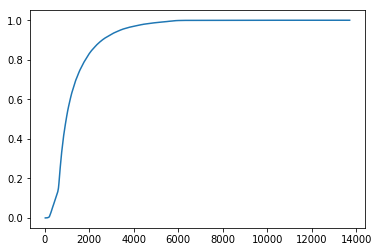

In [10]:
sent_pentage_list = [(count/sum(sent_freq)) for count in accumulate(sent_freq)]
plt.plot(sent_length, sent_pentage_list)

In [11]:
# 寻找分位点为quantile的句子长度
quantile = 0.91
#print(list(sent_pentage_list))
for length, per in zip(sent_length, sent_pentage_list):
    if round(per, 2) == quantile:
        index = length
        break
print("\n分位点为%s的句子长度:%d." % (quantile, index))


分位点为0.91的句子长度:2655.


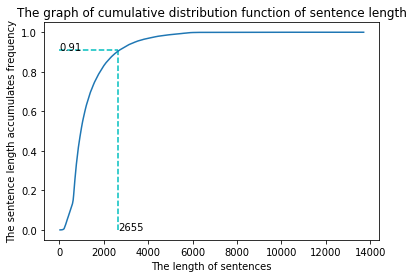

In [12]:
# 绘制句子长度累积分布函数图
plt.plot(sent_length, sent_pentage_list)
plt.hlines(quantile, 0, index, colors="c", linestyles="dashed")
plt.vlines(index, 0, quantile, colors="c", linestyles="dashed")
plt.text(0, quantile, str(quantile))
plt.text(index, 0, str(index))
plt.title("The graph of cumulative distribution function of sentence length")
plt.xlabel("The length of sentences")
plt.ylabel("The sentence length accumulates frequency")
plt.savefig("./The graph of cumulative distribution function of sentence length.png")
plt.show()
plt.close()

In [13]:
embedding_vector_size = 100
w2v_model = Word2Vec(
    sentences=sentences,
    size=embedding_vector_size,sg=1, hs=1,
    min_count=2, window=5, workers=4)
w2v_model.save("word2vec_100dim_sg1_hs1.model")

In [14]:
embedding_vector_size = 200
w2v_model = Word2Vec(
    sentences=sentences,
    size=embedding_vector_size,sg=1, hs=1,
    min_count=2, window=5, workers=4)
w2v_model.save("word2vec_"+str(embedding_vector_size)+"dim_sg1_hs1.model")

In [17]:
import numpy as np
w2v_model = Word2Vec.load('word2vec_100dim_sg1_hs1.model')


# 取得所有单词
vocab_list = list(w2v_model.wv.vocab.keys())
# 每个词语对应的索引
word_index = {word: index for index, word in enumerate(vocab_list)}
# 序列化
def get_index(sentence):
    global word_index
    sequence = []
    for word in sentence:
        try:
            sequence.append(word_index[word])
        except KeyError:
            pass
    return sequence
X_data = list(map(get_index, sentences))

# 截长补短
# max_len 根据中位数和平均值得来的
maxlen = 100
X_pad = pad_sequences(X_data, maxlen=maxlen)
# 取得标签
Y = data.label.values
np.save("Y.npy",Y)
# 划分数据集
X_train, X_test, Y_train, Y_test = train_test_split(
    X_pad,
    Y,
    test_size=0.2,
    random_state=42)
np.save("X_train.npy",X_train)
np.save("X_test.npy",X_test)
np.save("Y_train.npy",Y_train)
np.save("Y_test.npy",Y_test)
np.save("all_sentences.npy",sentences)

In [28]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import TensorBoard

# 让 Keras 的 Embedding 层使用训练好的Word2Vec权重
embedding_matrix = w2v_model.wv.vectors

model = Sequential()
model.add(Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    input_length=maxlen,
    weights=[embedding_matrix],
    trainable=False))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)
# logdir = "./logs/"
# tensorBoard = TensorBoard(log_dir = logdir,
#                                     histogram_freq = 1,
#                                     write_graph = True,
#                                     write_images = False,
#                                     embeddings_freq = 1,
#                                     embeddings_layer_names = None,
#                                     embeddings_metadata = None)

history = model.fit(
    x=X_train,
    y=Y_train,
    validation_data=(X_test, Y_test),
    batch_size=2048,
    epochs=100,
#     callbacks=[tensorBoard]
) 
# model_save_path= './labelled_train_test_model.h5'
model_save_path= './imdb_train_test_model_BILSTM2.h5'
model.save(model_save_path)

Train on 60000 samples, validate on 15000 samples
Epoch 1/100
60000/60000 [==============================] - 11s 185us/step - loss: 0.7156 - acc: 0.5054 - val_loss: 0.6787 - val_acc: 0.5513
Epoch 2/100
60000/60000 [==============================] - 9s 154us/step - loss: 0.6743 - acc: 0.5810 - val_loss: 0.6431 - val_acc: 0.6285
Epoch 3/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.6569 - acc: 0.6065 - val_loss: 0.6395 - val_acc: 0.6310
Epoch 4/100
60000/60000 [==============================] - 9s 157us/step - loss: 0.6393 - acc: 0.6305 - val_loss: 0.6214 - val_acc: 0.6486
Epoch 5/100
60000/60000 [==============================] - 9s 154us/step - loss: 0.6252 - acc: 0.6449 - val_loss: 0.6126 - val_acc: 0.6545
Epoch 6/100
60000/60000 [==============================] - 9s 149us/step - loss: 0.6181 - acc: 0.6561 - val_loss: 0.6087 - val_acc: 0.6599
Epoch 7/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.6161 - acc: 0.6565 - val_loss: 0

In [29]:
def plot_loss_accuracy(his):
    loss = his.history['loss']
    val_loss = his.history['val_loss']
    acc = his.history['acc']
    val_acc = his.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(12,6))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

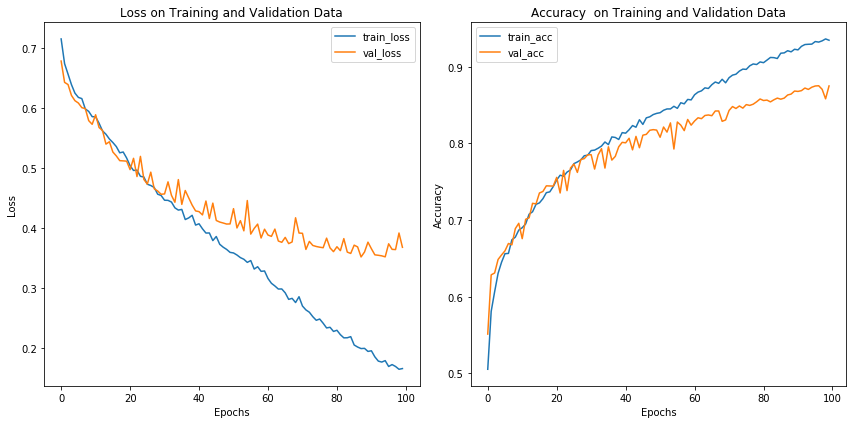

In [30]:
plot_loss_accuracy(history)

In [31]:


def plot_confusion_matrix(cm, classes,title="Confusion Matrix",cmap=plt.cm.Blues):
    """
    The function prints and plots the confusion matrix
    """
    plt.imshow(cm,interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=0)
    plt.yticks(tick_marks,classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],horizontalalignment = 'center',
        color="white" if cm[i,j]>thresh else"black")
        
    plt.tight_layout()
    plt.ylabel("True label")

accuracy metric in the testing dataset:  0.8749333333333333
precision metric in the testing dataset:  0.8833693304535637
recall metric in the testing dataset:  0.8660667019587083
specificity metric in the testing dataset:  0.8839333691563676
F1 score metric in the testing dataset:  0.8746324512162523


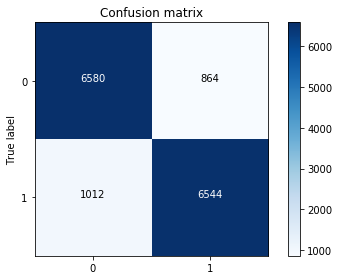

In [32]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
cnf_matrix = confusion_matrix(Y_test, y_pred)
accuracy = (cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[0,1]+cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[0,1])
recall = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
specificity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
f1 = 2*precision*recall/(precision+recall)
print("accuracy metric in the testing dataset: ", accuracy)
print("precision metric in the testing dataset: ", precision)
print("recall metric in the testing dataset: ", recall)
print("specificity metric in the testing dataset: ", specificity)
print("F1 score metric in the testing dataset: ", f1)
class_names=[0,1]
plt.figure
plot_confusion_matrix(cnf_matrix,classes=class_names, title="Confusion matrix")
plt.show()

In [73]:
# 序列化
def get_predict_index(sentence,word_index):
    sequence = []
    for word in sentence:
        try:
            sequence.append(word_index[word])
        except KeyError:
            continue
    return sequence

In [74]:
from keras.models import load_model
def predict(text,word2_vecpath,model_path):
    predict_model = load_model(model_path)
    stopwords = load_stopwords("stop_all.txt")
    sentence = clean_review(text)
    w2v = Word2Vec.load(word2_vecpath)
    # 取得所有单词
    vocab_list = list(w2v_model.wv.vocab.keys())
    # 每个词语对应的索引
    word_index = {word: index for index, word in enumerate(vocab_list)}
    seq_sentence = get_predict_index(sentence,word_index)
    maxlen = 100
    X_pad = pad_sequences([seq_sentence], maxlen=maxlen)
    y_pred = predict_model.predict_classes(X_pad)
    t_prob = predict_model.predict_proba(X_pad)
    print(y_pred,t_prob)

In [75]:
text="This movie is one among the very few Indian movies, that would never fade away with the passage of time, nor would its spell binding appeal ever diminish, even as the Indian cinema transforms into the abyss of artificially styled pop culture while drill oriented extras take to enhancing the P.T. styled film songs.<br /><br />The cinematography speaks of the excellent skills of Josef Werching that accentuate the monumental and cinema scope effect of the film in its entirety.<br /><br />Gone are the days of great cinema, when every scene had to be clipped many times and retakes taken before finalizing it, while meticulous attention was paid in crafting and editing the scenes. Some of its poignant scenes are filled with sublime emotional intensity, like the instance, when Meena Kumari refuses to say \"YES\" as an approval for Nikah (Marriage Bond) and climbs down the hill while running berserk in traumatized frenzy. At the moment, Raj Kumar follows her, and a strong gale of wind blew away the veil of Kumari and onto the legs of Kumar........<br /><br />Kamal Amrohi shall always be remembered with golden words in the annals of Indian Cinema's history for endeavoring to complete this movie in a record setting 12 years. He had to manage filming of some of the vital songs without Meena's close ups, because Meena Kumari, the lady in the lead role was terminally ill and fighting for her life in early 1971."
word2_vecpath='./word2vec_100dim_sg1_hs1.model'
model_path="./imdb_train_test_model_BILSTM2.h5"
predict(text,word2_vecpath,model_path)

[[1]] [[0.9754706]]


In [65]:
stopwords = load_stopwords("stop_all.txt")
sentence = clean_review(text)
w2v = Word2Vec.load(word2_vecpath)
# 取得所有单词
vocab_list = list(w2v_model.wv.vocab.keys())
# 每个词语对应的索引
word_index = {word: index for index, word in enumerate(vocab_list)}
seq_sentence = get_predict_index(sentence,word_index)
maxlen = 100
seq_sentence

[12422,
 72274,
 78289,
 106698,
 109854,
 117079,
 27431,
 83963,
 19752,
 29019,
 72274,
 76890,
 7332,
 33041,
 14062,
 59045,
 101917,
 27382,
 94663,
 85404,
 32125,
 80633,
 80857,
 67119,
 59045,
 13352,
 8705,
 76687,
 16311,
 43355,
 81134,
 101767,
 72849,
 19,
 63625,
 76890,
 79320,
 54644,
 13352,
 64818,
 54441,
 82665,
 76890,
 55652,
 48999,
 11943,
 106011,
 90473,
 82242,
 117923,
 84733,
 89113,
 115191,
 95555,
 68979,
 95555,
 100938,
 14679,
 38080,
 108476,
 2132,
 112291,
 23656,
 39767,
 95827,
 88894,
 18683,
 38644,
 7700,
 55875,
 57334,
 28543,
 41577,
 45799,
 105850,
 66357,
 55774,
 115887,
 105238,
 7623,
 52175,
 81011,
 23656,
 86751,
 55774,
 71671,
 3539,
 32350,
 70511,
 103392,
 117002,
 72274,
 47784,
 94684,
 82850,
 66796,
 12422,
 92882,
 3594,
 116502,
 34218,
 109537,
 86699,
 20905,
 8705,
 73808,
 29541,
 46290,
 112291,
 23656,
 38871,
 5031,
 2635,
 21930,
 16888,
 51294,
 40985,
 112698,
 53474]

In [66]:
X_pad = pad_sequences([seq_sentence], maxlen=maxlen)
X_pad

array([[ 85404,  32125,  80633,  80857,  67119,  59045,  13352,   8705,
         76687,  16311,  43355,  81134, 101767,  72849,     19,  63625,
         76890,  79320,  54644,  13352,  64818,  54441,  82665,  76890,
         55652,  48999,  11943, 106011,  90473,  82242, 117923,  84733,
         89113, 115191,  95555,  68979,  95555, 100938,  14679,  38080,
        108476,   2132, 112291,  23656,  39767,  95827,  88894,  18683,
         38644,   7700,  55875,  57334,  28543,  41577,  45799, 105850,
         66357,  55774, 115887, 105238,   7623,  52175,  81011,  23656,
         86751,  55774,  71671,   3539,  32350,  70511, 103392, 117002,
         72274,  47784,  94684,  82850,  66796,  12422,  92882,   3594,
        116502,  34218, 109537,  86699,  20905,   8705,  73808,  29541,
         46290, 112291,  23656,  38871,   5031,   2635,  21930,  16888,
         51294,  40985, 112698,  53474]], dtype=int32)

In [67]:
X_test[0]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,  25546,  11085,    856,  13352,
         1025,  35641,  30233,  40467,   1025,  35641,  13002,  82782,
        61411,  18540,  82332,  27789,  44110, 114298, 117578,  46624,
        89132,   4445,  87509,  12335,  35531,  37032, 117079,  35531,
         4191,   1020,  13352,   4191,  63626,  85111,  40740,  63979,
       103135,  34993,  59819,   7407, 110994,  59217,  46780,  25546,
        11085,    856,  57827,  82654,  86450,   1025,  35641, 115832,
        12422,   3050,   7342,  89046,  80288,  69332,  12500,  94721,
        65901, 107423,  40467,  13352, 120459,  54026,  55652, 112816,
       106624,  85634,  13352,  44862,  81681, 116944,   3938,  95555,
        51914,   5313, 116505, 102832, 101729,  39800,  13352, 117955,
        36687,  99253,  69485,  69485], dtype=int32)

In [68]:
X_pad[0]

array([ 85404,  32125,  80633,  80857,  67119,  59045,  13352,   8705,
        76687,  16311,  43355,  81134, 101767,  72849,     19,  63625,
        76890,  79320,  54644,  13352,  64818,  54441,  82665,  76890,
        55652,  48999,  11943, 106011,  90473,  82242, 117923,  84733,
        89113, 115191,  95555,  68979,  95555, 100938,  14679,  38080,
       108476,   2132, 112291,  23656,  39767,  95827,  88894,  18683,
        38644,   7700,  55875,  57334,  28543,  41577,  45799, 105850,
        66357,  55774, 115887, 105238,   7623,  52175,  81011,  23656,
        86751,  55774,  71671,   3539,  32350,  70511, 103392, 117002,
        72274,  47784,  94684,  82850,  66796,  12422,  92882,   3594,
       116502,  34218, 109537,  86699,  20905,   8705,  73808,  29541,
        46290, 112291,  23656,  38871,   5031,   2635,  21930,  16888,
        51294,  40985, 112698,  53474], dtype=int32)

In [69]:
from keras.models import load_model
model = load_model(model_path)
y_pred = model.predict_classes(X_pad)
t_prob = model.predict_proba(X_pad)
print(y_pred,t_prob)

[[1]] [[0.9754706]]
